In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util
import seaborn as sns
import numpy as np
import collections
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
from scipy import ndimage
from datetime import date
import pickle
import re
import warnings

import warnings
warnings.filterwarnings('ignore')

today = date.today()
cid = '' # client ID
secret = '' # client secret
rur = 'http://www.example.com/callbacks' # redirected URI
scope = 'user-library-read' # допуск к возможностям API
user = '' # имя пользователя

print_characteristics = True
is_savefig = True

In [6]:
token=SpotifyOAuth(username=user,
                          scope=scope,
                          client_id=cid,
                          client_secret=secret,
                          redirect_uri=rur)

sp = spotipy.Spotify(auth_manager=token)

In [15]:
lib = {'artist':[],             # исполнитель
       'track':[],              # название трека
       'id':[],                 # id в библиотеке spotify
       'acousticness':[],       # акустичность (от 0 до 1)
       'danceability':[],       # танцевальность (оценка темпа, стабильности ритма, силы битов и общей регулярности от 0 до 1)
       'duration':[],           # длительность (мс)
       'energy':[],             # энергичность (от 0 до 1)
       'instrumentalness':[],   # инструментал
       'key':[],                # преобладание тональности
       'liveness':[],           # слушатели в записи
       'loudness':[],           # помехи в записи: 0 - чистый; -inf - шум
       'mode':[],               # минор - 0; мажор - 1
       'speechiness':[],        # голос
       'tempo':[],              # темп
       'time_signature':[],     # размерность (четверти)
       'valence':[]}            # позитивность

pitches_lib = {'notes': ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'],
               'count': []}

modes_lib = {'mode': ['MINOR', 'MAJOR'],
             'count':[]}

polar_params = {'valence':[],
                'energy':[],
                'danceability':[],
                'acousticness':[],
                'instrumentalness':[],
                'liveness':[],
                'speechiness':[]
                }

In [16]:
loadlib = pd.read_pickle('library.pkl')

In [17]:
loadlib['duration'] = [duration/6e4 for duration in loadlib['duration']]

tracks_pitch = dict(collections.Counter(loadlib['key']))
tracks_pitch = [tracks_pitch[ind] for ind in sorted(tracks_pitch)]
tracks_pitch = tracks_pitch/np.sum(tracks_pitch)*100

tracks_tone = dict(collections.Counter(loadlib['mode']))
tracks_tone = [tracks_tone[ind] for ind in sorted(tracks_tone)]
tracks_tone = tracks_tone/np.sum(tracks_tone)*100

pitches_lib['number'] = tracks_pitch
modes_lib['number'] = tracks_tone

In [19]:
loadlib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            600 non-null    object 
 1   track             600 non-null    object 
 2   id                600 non-null    object 
 3   acousticness      600 non-null    float64
 4   danceability      600 non-null    float64
 5   duration          600 non-null    float64
 6   energy            600 non-null    float64
 7   instrumentalness  600 non-null    float64
 8   key               600 non-null    int64  
 9   liveness          600 non-null    float64
 10  loudness          600 non-null    float64
 11  mode              600 non-null    int64  
 12  speechiness       600 non-null    float64
 13  tempo             600 non-null    float64
 14  time_signature    600 non-null    int64  
 15  valence           600 non-null    float64
dtypes: float64(10), int64(3), object(3)
memory u

In [11]:
loadlib.describe()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.00000,600.000000
mean,0.180969,0.544137,4.408390,0.710434,0.309376,5.528333,0.190416,-7.807065,0.473333,0.095180,122.840643,3.92500,0.381535
std,0.280957,0.190883,1.846857,0.224324,0.384145,3.655791,0.153998,4.419890,0.499705,0.099967,28.594629,0.35532,0.258335
min,0.000004,0.061900,0.691550,0.046200,0.000000,0.000000,0.034900,-27.928000,0.000000,0.024200,61.290000,1.00000,0.031600
25%,0.001553,0.423750,3.305617,0.614750,0.000023,2.000000,0.096175,-9.429000,0.000000,0.037000,100.010250,4.00000,0.160500
50%,0.033050,0.555000,4.013250,0.767500,0.015950,6.000000,0.120500,-6.624500,0.000000,0.051500,121.968500,4.00000,0.333500
75%,0.219000,0.685250,5.068567,0.881250,0.781250,9.000000,0.247750,-4.825500,1.000000,0.105250,140.012250,4.00000,0.569500
max,0.985000,0.945000,20.000000,0.996000,0.974000,11.000000,0.944000,-0.759000,1.000000,0.829000,199.865000,5.00000,0.970000


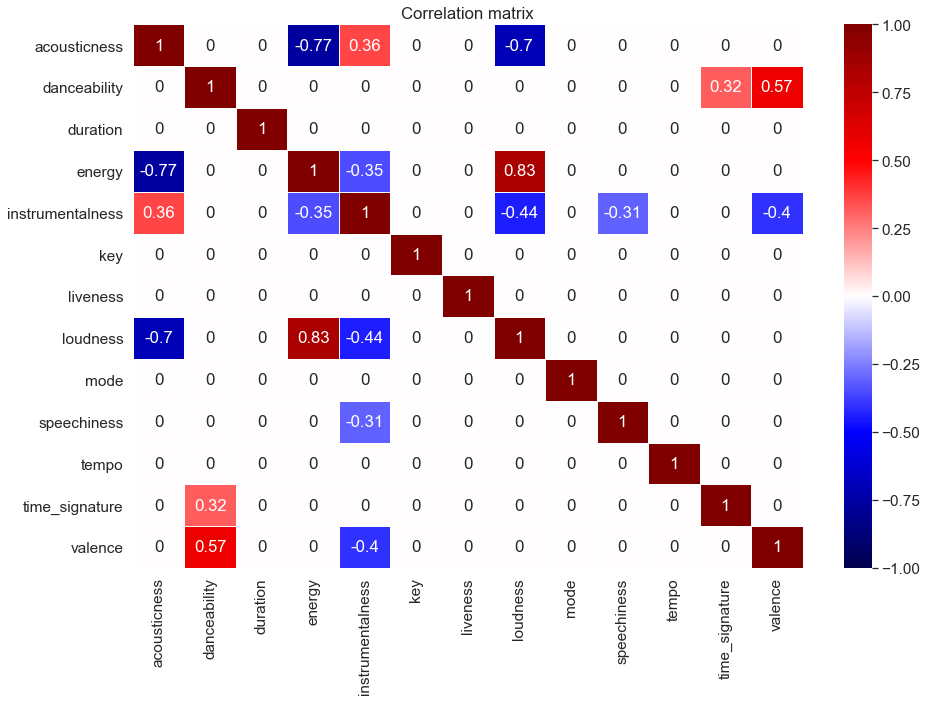

In [20]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = loadlib.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='seismic', vmin = -1, vmax = 1)

plt.title('Correlation matrix')
plt.show()

In [64]:
loadlib.head(10)

,artist,track,id,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Патология,Протест,699rgXgvbMwJpFEfaeJtZL,0.021100,0.679,2.094617,0.609,0.000003,11,0.0889,-8.033,0,0.0432,133.379,4,0.7410
1,Benny Benassi,Shooting Helicopters (feat. Serj Tankian) - Ra...,0ZffrGElMGm94yQ2qpirXh,0.088700,0.618,3.455517,0.675,0.000150,4,0.0732,-6.282,0,0.0619,128.000,4,0.3150
2,Mattafix,Gangster Blues,00Jiy2HCQrpELyLXSI6YpW,0.023100,0.561,4.320450,0.665,0.167000,7,0.1200,-7.600,0,0.1670,158.974,4,0.3910
3,Pawel Blaszczak,On the Edge of Light,5DtfQO2cdT47GxaEZ5HbGg,0.959000,0.472,4.499917,0.193,0.920000,0,0.1150,-20.258,0,0.0355,74.988,4,0.2470
4,Raekwon,"Ice Cream (feat. Ghostface Killah, Method Man ...",6SI4JD7iyQ0rrudhCNtMv0,0.219000,0.683,4.220450,0.902,0.000761,1,0.2260,-7.389,0,0.2910,90.447,4,0.7240
5,Magic Sword,The Curse,0brJjUujIzKEbjeicUIeha,0.000453,0.363,5.624067,0.793,0.000463,8,0.1240,-6.290,1,0.0590,133.040,4,0.0394
6,April Rain,My Silent Angel,18iJlo9hMwtOIngFVuFQ34,0.003470,0.262,4.947150,0.941,0.797000,7,0.0646,-4.506,0,0.1210,180.091,3,0.1140
7,Sektor Gaza,Носки,0he0dqeKTD57XVRRjCMZTT,0.673000,0.710,2.781117,0.963,0.060000,4,0.1890,-7.649,0,0.0537,132.930,4,0.8890
8,Fort Minor,Where'd You Go (feat. Holly Brook & Jonah Matr...,1KVPQ3XQnmhjPbyXs6AcAS,0.262000,0.684,3.864450,0.819,0.001970,1,0.1130,-3.309,0,0.2380,179.999,4,0.2500
9,Danger,4:30,0lO8ZTS4kNYa9eOSC1QYQi,0.013300,0.721,4.532450,0.934,0.468000,8,0.0915,-4.832,1,0.0467,128.999,4,0.1630


[Text(0, 0.5, '%')]

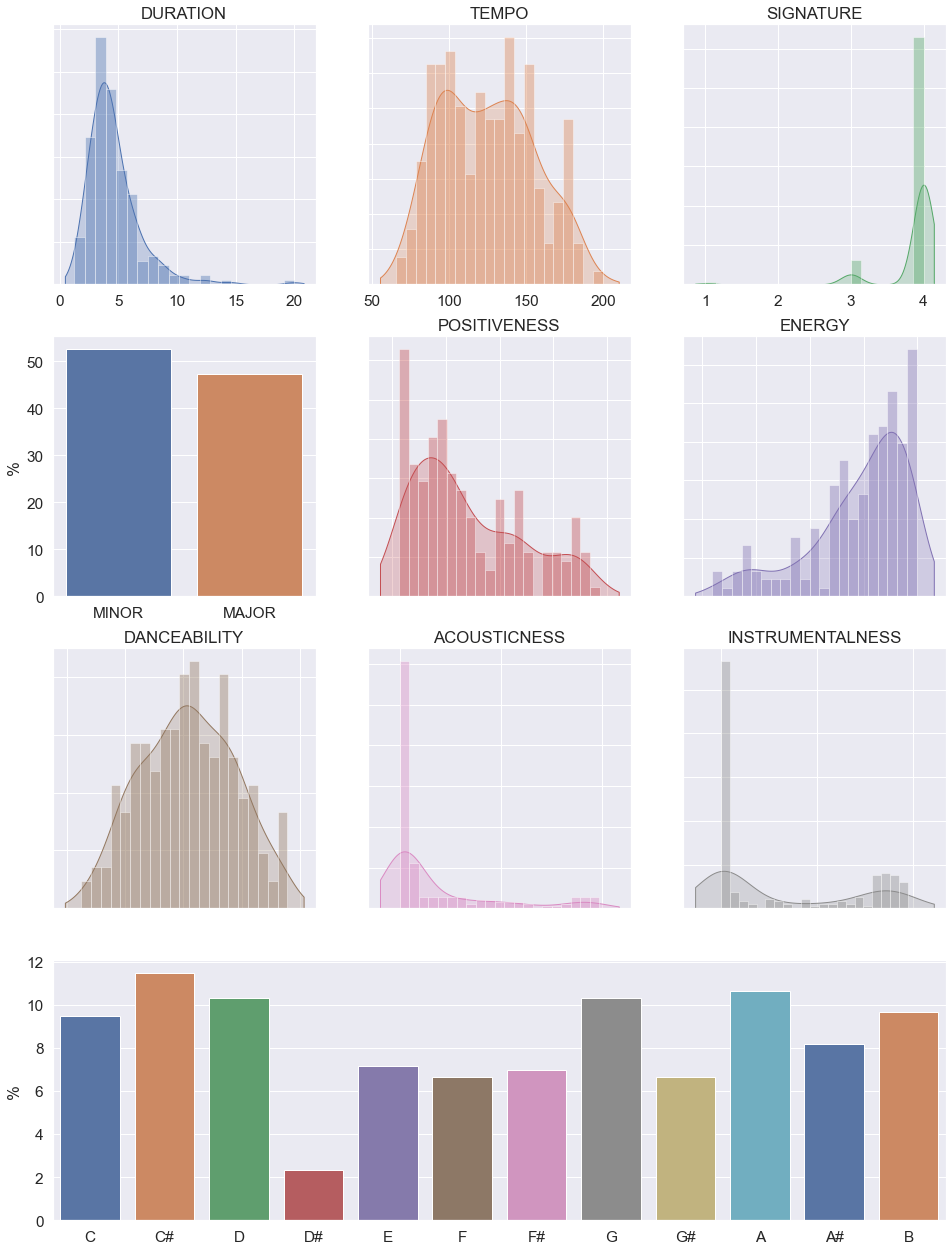

In [24]:
plt.figure(figsize=(16, 22))
colors = sns.color_palette("deep", 9)
sns.set_style()
bins = 21


plt.subplot (431)
sns.distplot(lib['duration'], bins = bins, 
              color=colors[0], kde=False, norm_hist=True)
dur = sns.kdeplot(lib['duration'], color=colors[0],
                  shade = True, cut = True)
dur.set(xlabel=None)
dur.set(ylabel = None)
dur.set(yticklabels = [])
plt.title('DURATION')

plt.subplot (432)
sns.distplot(lib['tempo'], color=colors[1], bins = bins, 
            kde=False, norm_hist=True)
temp = sns.kdeplot(lib['tempo'], color=colors[1],
                   shade = True, cut = True)
temp.set(xlabel=None)
temp.set(ylabel = None)
temp.set(yticklabels = [])
plt.title('TEMPO')

plt.subplot(433)
sns.distplot(lib['time_signature'], color=colors[2], kde=False, norm_hist=True, bins = bins)
signature = sns.kdeplot(lib['time_signature'], 
                        shade = True, cut = True, color=colors[2])
signature.set(xlabel=None)
signature.set(ylabel = None)
signature.set(yticklabels = [])
plt.title('SIGNATURE')


plt.subplot(434)
mode = sns.barplot(x=modes_lib['mode'], y=modes_lib['number'], palette = 'deep')
mode.set(ylabel = '%')

plt.subplot (435)
sns.distplot(lib['valence'], color=colors[3], bins = bins,
             kde=False, norm_hist=True)
valence = sns.kdeplot(lib['valence'], color=colors[3], label='Positiveness, rel', shade = True, cut = True)
valence.set(xlabel=None)
valence.set(ylabel = None)
valence.set(yticklabels = [])
valence.set(xticklabels = [])
plt.title('POSITIVENESS')

plt.subplot(436)
sns.distplot(lib['energy'], color=colors[4], kde=False, norm_hist=True, bins = bins)
energy = sns.kdeplot(lib['energy'], color=colors[4], shade = True, cut = True)
energy.set(xlabel=None)
energy.set(ylabel = None)
energy.set(yticklabels = [])
energy.set(xticklabels = [])
plt.title('ENERGY')


plt.subplot(437)
sns.distplot(lib['danceability'], color=colors[5], kde=False, norm_hist=True, bins = bins)
danceability = sns.kdeplot(lib['danceability'], color=colors[5], shade = True, cut = True)
danceability.set(xlabel=None)
danceability.set(ylabel = None)
danceability.set(yticklabels = [])
danceability.set(xticklabels = [])
plt.title('DANCEABILITY')

plt.subplot(438)
sns.distplot(lib['acousticness'], color=colors[6], kde=False, norm_hist=True, bins = bins)
acousticness = sns.kdeplot(lib['acousticness'], color=colors[6], shade = True, cut = True)
acousticness.set(xlabel=None)
acousticness.set(ylabel = None)
acousticness.set(yticklabels = [])
acousticness.set(xticklabels = [])
plt.title('ACOUSTICNESS')

plt.subplot(439)
sns.distplot(lib['instrumentalness'], color=colors[7], kde=False, norm_hist=True, bins = bins)
instrumentalness = sns.kdeplot(lib['instrumentalness'], color=colors[7], shade = True, cut = True)
instrumentalness.set(xlabel=None)
instrumentalness.set(ylabel = None)
instrumentalness.set(yticklabels = [])
instrumentalness.set(xticklabels = [])
plt.title('INSTRUMENTALNESS')


plt.subplot (414) #number of rows, number of columns, num of element
notes = sns.barplot(x=pitches_lib['notes'], y=pitches_lib['number'], palette = 'deep')
notes.set(ylabel = '%')

#plt.savefig('library_analysis1_%s.pdf'%today.strftime("%Y-%m-%d"), dpi = 300)

In [66]:
lib = {'artist':[],             # исполнитель
       'track':[],              # название трека
       'id':[],                 # id в библиотеке spotify
       'acousticness':[],       # акустичность (от 0 до 1)
       'danceability':[],       # танцевальность (оценка темпа, стабильности ритма, силы битов и общей регулярности от 0 до 1)
       'duration':[],           # длительность (мс)
       'energy':[],             # энергичность (от 0 до 1)
       'instrumentalness':[],   # инструментал
       'key':[],                # преобладание тональности
       'liveness':[],           # слушатели в записи
       'loudness':[],           # помехи в записи: 0 - чистый; -inf - шум
       'mode':[],               # минор - 0; мажор - 1
       'speechiness':[],        # голос
       'tempo':[],              # темп
       'time_signature':[],     # размерность (четверти)
       'valence':[]}            # позитивность

pitches_lib = {'notes': ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'],
               'count': []}

modes_lib = {'mode': ['MINOR', 'MAJOR'],
             'count':[]}

polar_params = {'valence':[],
                'energy':[],
                'danceability':[],
                'acousticness':[],
                'instrumentalness':[],
                'liveness':[],
                'speechiness':[]
                }


i = 0
s = 0
while True:

        results = sp.current_user_saved_tracks(limit=50, offset=i)

        if len(results['items']) != 0:
            for _, item in enumerate(results['items']):
                
                track_info = item['track']
                track_id = track_info['id']
                track_artist = track_info['artists'][0]['name']
                track_name = track_info['name']
    
                lib['id'].append(track_id)
                lib['track'].append(track_name)
                lib['artist'].append(track_artist)
                
                s += 1
                #if print_characteristics == False:
                print('%i: %s - %s' % (s, track_artist, track_name))

            i+=50

        else:
            break

1: Power Glove - Trials of the Blood Dragon
2: Benny Benassi - Shooting Helicopters (feat. Serj Tankian) - Radio Edit
3: Mattafix - Gangster Blues
4: Pawel Blaszczak - On the Edge of Light
5: Raekwon - Ice Cream (feat. Ghostface Killah, Method Man & Cappadonna)
6: Magic Sword - The Curse
7: April Rain - My Silent Angel
8: Sektor Gaza - Носки
9: Fort Minor - Where'd You Go (feat. Holly Brook & Jonah Matranga)
10: Danger - 4:30
11: Krovostok - Куртец
12: Apparat - CARONTE
13: Sektor Gaza - Не дает
14: Fever the Ghost - Source
15: Sektor Gaza - Видак
16: R-Tem - Voiceless - Z05 Mix
17: MALO - March of Progress
18: OVERWERK - Toccata
19: OVERWERK - Daybreak
20: Dan Balan - Hold on Love
21: Slider & Magnit - Morze
22: Röyksopp - Here She Comes Again - DJ Antonio Extended Mix
23: Besomage - Thank You
24: Sarah de Warren - Astronomy
25: Tame Impala - Elephant
26: eevee - viola
27: DJ Chris Parker - Symphony 2011
28: Giorgos Mazonakis - To Gucci Forema - original
29: Eric Prydz - Proper Educat

251: Kosmischer Läufer - In der Stadt und auf dem Land
252: Ashbringer - Spiritual Architecture
253: Brand of Sacrifice - Lifeblood
254: 7GreeNs - Pentagramma (Remix)
255: The Who - Eminence Front
256: The Cars - Moving in Stereo
257: Men Without Hats - The Safety Dance (Extended Club Mix)
258: Abyssphere - Демон строк
259: 65daysofstatic - End Of The World Sun
260: Del Amitri - Long Way Down
261: Keane - Everybody's Changing
262: Mooncake - Mandarin - Acoustic
263: Gorillaz - Rhinestone Eyes
264: Daryl Hall & John Oates - Maneater
265: Message To Bears - Running Through Woodland
266: Bear's Den - Above The Clouds Of Pompeii
267: Machine Gun Kelly - Till I Die
268: Denis Stelmakh - Secret Invasion
269: Joywave - Going to a Place
270: Joywave - Smokestacks
271: The Comet Is Coming - Start Running
272: This Will Destroy You - They Move on Tracks of Never-Ending Light
273: Slipknot - Snuff
274: Stealers Wheel - Stuck In The Middle With You
275: Dynoro - In My Mind
276: Françoise Hardy - N

501: Jeremy Soule - Awake
502: Adam Skorupa - Assassins Of Kings
503: Percival - The Song Of The Sword-Dancer
504: Pawel Blaszczak - River Of Life
505: Eminem - Elevator
506: Eminem - Buffalo Bill
507: Eminem - Lucky You (feat. Joyner Lucas)
508: Eminem - Greatest
509: Eminem - Godzilla (feat. Juice WRLD)
510: Oxxxymiron - Жук в муравейнике
511: Oxxxymiron - В говне
512: Oxxxymiron - Спонтанное самовозгорание
513: Oxxxymiron - Детектор лжи
514: Oxxxymiron - Пролив Дрейка
515: Oxxxymiron - Слово мэра
516: Oxxxymiron - Всего лишь писатель
517: Oxxxymiron - Город под подошвой
518: Oxxxymiron - Где нас нет
519: Jesper Kyd - The Skaven Come Out To Play
520: Jesper Kyd - Skaven Camp Located
521: Jason Hayes - Tavern
522: Motoi Sakuraba - Firelink Shrine
523: Anup Sastry - Titan
524: Mick Gordon - Bfg Division
525: Power Glove - Power Core
526: Bi-2 - Полковнику никто не пишет
527: The Dillinger Escape Plan - Farewell, Mona Lisa
528: The Dillinger Escape Plan - Panasonic Youth
529: The Dillin

In [67]:
track_info.keys()

dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri'])

In [68]:
lz_uri = 'spotify:artist:36QJpDe2go2KgaRleHCDTp'

#spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())
results = sp.artist_top_tracks(lz_uri)

for track in results['tracks'][:10]:
    print('track    : ' + track['name'])
    print('audio    : ' + track['preview_url'])
    print('cover art: ' + track['album']['images'][0]['url'])
    print()

track    : Stairway to Heaven - Remaster
audio    : https://p.scdn.co/mp3-preview/8226164717312bc411f8635580562d67e191a754?cid=0d894d41d74d4e979d69f74e09872e54
cover art: https://i.scdn.co/image/ab67616d0000b273c8a11e48c91a982d086afc69

track    : Immigrant Song - Remaster
audio    : https://p.scdn.co/mp3-preview/8455599677a13017978dcd3f4b210937f0a16bcb?cid=0d894d41d74d4e979d69f74e09872e54
cover art: https://i.scdn.co/image/ab67616d0000b27390a50cfe99a4c19ff3cbfbdb

track    : Whole Lotta Love - 1990 Remaster
audio    : https://p.scdn.co/mp3-preview/ce11b19a4d2de9976d7626df0717d0073863909c?cid=0d894d41d74d4e979d69f74e09872e54
cover art: https://i.scdn.co/image/ab67616d0000b273fc4f17340773c6c3579fea0d

track    : Black Dog - Remaster
audio    : https://p.scdn.co/mp3-preview/9b76619fd9d563a48d38cc90ca00c3008327b52e?cid=0d894d41d74d4e979d69f74e09872e54
cover art: https://i.scdn.co/image/ab67616d0000b273c8a11e48c91a982d086afc69

track    : Kashmir - Remaster
audio    : https://p.scdn.co/mp3

In [ ]:
track_info['name']

In [ ]:
sp.audio_features('0q6LuUqGLUiCPP1cbdwFs3')

In [ ]:
sp.recommendation_genre_seeds()

In [72]:
sp.track('0q6LuUqGLUiCPP1cbdwFs3')['name']

'On Melancholy Hill'

In [90]:
sp.audio_analysis('0q6LuUqGLUiCPP1cbdwFs3')['bars']

[{'start': 1.10621, 'duration': 1.99372, 'confidence': 0.448},
 {'start': 3.09994, 'duration': 1.99362, 'confidence': 0.48},
 {'start': 5.09356, 'duration': 1.99216, 'confidence': 0.541},
 {'start': 7.08572, 'duration': 1.9934, 'confidence': 0.585},
 {'start': 9.07912, 'duration': 1.9955, 'confidence': 0.548},
 {'start': 11.07462, 'duration': 1.99246, 'confidence': 0.19},
 {'start': 13.06708, 'duration': 1.99316, 'confidence': 0.752},
 {'start': 15.06024, 'duration': 1.9945, 'confidence': 0.488},
 {'start': 17.05473, 'duration': 1.99207, 'confidence': 0.672},
 {'start': 19.0468, 'duration': 1.99769, 'confidence': 0.454},
 {'start': 21.04449, 'duration': 2.00071, 'confidence': 0.851},
 {'start': 23.0452, 'duration': 1.98796, 'confidence': 0.687},
 {'start': 25.03316, 'duration': 1.991, 'confidence': 0.242},
 {'start': 27.02415, 'duration': 1.99329, 'confidence': 0.669},
 {'start': 29.01744, 'duration': 1.99521, 'confidence': 0.492},
 {'start': 31.01265, 'duration': 1.99126, 'confidence'

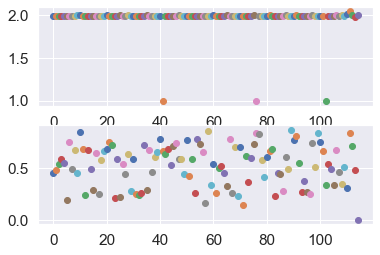

In [98]:
bars = sp.audio_analysis('0q6LuUqGLUiCPP1cbdwFs3')['bars']

some_list = []
for i, bar in enumerate(bars):
    #print(i, bar)
    plt.subplot(211)
    plt.scatter(i, bar['duration'])
    plt.subplot(212)
    plt.scatter(i, bar['confidence'])
    


In [ ]:
rec = sp.recommendations(seed_tracks=['0q6LuUqGLUiCPP1cbdwFs3'], limit=100, 
                         target_valence=0.5, 
                         target_instrumentalness=0.5,
                         target_danceability=0.7)

rec_lib = {'valence':[],
          'instrumentalness':[],
          'danceability':[]}
for i, track in enumerate(rec['tracks'], 1):
    info = track['id']
    author = track['artists'][0]['name']
    song = track['name']
    
    rec_lib['valence'].append(sp.audio_features(info)[0]['valence'])
    rec_lib['instrumentalness'].append(sp.audio_features(info)[0]['instrumentalness'])
    rec_lib['danceability'].append(sp.audio_features(info)[0]['danceability'])
    
    print('%i: %s - %s'%(i, author, song))

In [ ]:
rec_lib = pd.DataFrame(rec_lib)

rec_lib['instrumentalness'].hist(bins=20, alpha = 0.5)
rec_lib['valence'].hist(bins=20, alpha = 0.5)
rec_lib['danceability'].hist(bins=20, alpha = 0.5)